In [5]:
from skimage.io import imread
from skimage.transform import resize
from skimage import img_as_float
import numpy as np
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Dropout, Input, concatenate, UpSampling2D
from keras.optimizers import Adam
from keras.initializers import he_normal
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
import glob


def unet(input_size = (256,256,3), seed=42, pretrained_weights = None, base = 32, actv='relu'):
    inputs = Input(input_size)
    kern_init = kernel_initializer=he_normal(seed=seed)
    conv1 = Conv2D(base,    3, activation=actv, padding='same', )(inputs)
    conv1 = Conv2D(base,    3, activation=actv, padding='same', kernel_initializer=kern_init)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(base*2,  3, activation=actv, padding='same', kernel_initializer=kern_init)(pool1)
    conv2 = Conv2D(base*2,  3, activation=actv, padding='same', kernel_initializer=kern_init)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(base*4,  3, activation=actv, padding='same', kernel_initializer=kern_init)(pool2)
    conv3 = Conv2D(base*4,  3, activation=actv, padding='same', kernel_initializer=kern_init)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(base*8,  3, activation=actv, padding='same', kernel_initializer=kern_init)(pool3)
    conv4 = Conv2D(base*8,  3, activation=actv, padding='same', kernel_initializer=kern_init)(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(base*16, 3, activation=actv, padding='same', kernel_initializer=kern_init)(pool4)
    conv5 = Conv2D(base*16, 3, activation=actv, padding='same', kernel_initializer=kern_init)(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6   = Conv2D(base*8,  2, activation=actv, padding='same', kernel_initializer=kern_init)(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(base*8,  3, activation=actv, padding='same', kernel_initializer=kern_init)(merge6)
    conv6 = Conv2D(base*8,  3, activation=actv, padding='same', kernel_initializer=kern_init)(conv6)

    up7   = Conv2D(base*4,  2, activation=actv, padding='same', kernel_initializer=kern_init)(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(base*4,  3, activation=actv, padding='same', kernel_initializer=kern_init)(merge7)
    conv7 = Conv2D(base*4,  3, activation=actv, padding='same', kernel_initializer=kern_init)(conv7)

    up8   = Conv2D(base*2,  2, activation=actv, padding='same', kernel_initializer=kern_init)(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(base*2,  3, activation=actv, padding='same', kernel_initializer=kern_init)(merge8)
    conv8 = Conv2D(base*2,  3, activation=actv, padding='same', kernel_initializer=kern_init)(conv8)

    up9   = Conv2D(base,    2, activation=actv, padding='same', kernel_initializer=kern_init)(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(base,    3, activation=actv, padding='same', kernel_initializer=kern_init)(merge9)
    conv9 = Conv2D(base,    3, activation=actv, padding='same', kernel_initializer=kern_init)(conv9)
    conv9 = Conv2D(2,       3, activation=actv, padding='same', kernel_initializer=kern_init)(conv9)
    conv10 = Conv2D(1,      1, activation = 'sigmoid')(conv9)

    model = Model(input = inputs, output = conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy', iou])
    
    if(pretrained_weights):
        model.load_weights(pretrained_weights)

    return model


def iou(y_true, y_pred):
    smooth=1e-5
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

In [6]:
model = unet(input_size=(256, 256, 3), base=48)

/home/dmitry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


In [7]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 256, 256, 48) 1344        input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_26 (Conv2D)              (None, 256, 256, 48) 20784       conv2d_25[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 128, 128, 48) 0           conv2d_26[0][0]                  
____________________________________________________________________________________________

In [163]:
from __future__ import print_function
from keras.preprocessing.image import ImageDataGenerator
import numpy as np 
import os
import glob
import skimage.io as io
import skimage.transform as trans


def trainGenerator(
    batch_size,
    image_path,
    mask_path,
    aug_dict,
    image_color_mode = "rgb",
    mask_color_mode = "grayscale",
    target_size = (256,256),
    seed = 1):
    '''
    can generate image and mask at the same time
    use the same seed for image_datagen and mask_datagen to ensure the transformation for image and mask is the same
    if you want to visualize the results of generator, set save_to_dir = "your path"
    '''
    image_datagen = ImageDataGenerator(
        rescale=1./255,
        samplewise_center=True,
        samplewise_std_normalization=True,
        **aug_dict)
    mask_datagen = ImageDataGenerator(rescale=1./255, **aug_dict)
    image_generator = image_datagen.flow_from_directory(
        image_path,
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        interpolation='bilinear',
        seed = seed)
    mask_generator = mask_datagen.flow_from_directory(
        mask_path,
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        interpolation='bilinear',
        seed = seed)
    train_generator = zip(image_generator, mask_generator)
    for (img,mask) in train_generator:
        yield (img,mask)

In [125]:
target_size=(256,256)
data_gen_args = dict(
    rotation_range=0.2,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True,
    fill_mode='nearest')
myGene = trainGenerator(
    batch_size=2,
    image_path='public_tests/00_test_val_input/train/images',
    mask_path='public_tests/00_test_val_input/train/gt',
    aug_dict=data_gen_args,
    target_size=target_size)
model = unet(input_size=(None, None, 3))
model_checkpoint = ModelCheckpoint('unet.hdf5', monitor='loss',verbose=1, save_best_only=True)

/home/dmitry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


In [98]:
untrained.fit_generator(myGene,steps_per_epoch=10,epochs=1)

Epoch 1/1
10/10 [==============================] - 50s 5s/step - loss: 0.4947 - accuracy: 0.8680


In [164]:
%matplotlib inline
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage import img_as_float

target_size = (256, 256)

def predict(model, img_path):
    img = img_as_float(imread(img_path))
    shape = img.shape
    inp = resize(img, target_size)
    if len(inp.shape) == 2:
        inp = np.array([inp, inp, inp]).transpose((1,2,0))
    inp -= inp.mean()
    inp /= inp.std()
    result = model.predict(np.array([inp]))[0]
    return resize(result, shape)[...,0]

In [141]:
img_path0 = 'public_tests/00_test_val_input/test/images/001.Black_footed_Albatross/Black_Footed_Albatross_0001_796111.jpg'
img_path1 = 'public_tests/00_test_val_input/test/images/009.Brewer_Blackbird/Brewer_Blackbird_0046_2688.jpg'
img_path2 = 'photo_2019-12-01_19-30-14.jpg'

In [133]:
img = img_as_float(imread(test_img_path))
shape = img.shape
inp = resize(img, target_size)

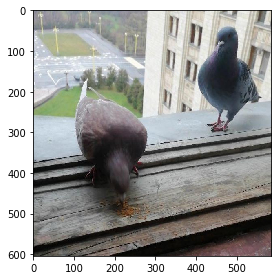

In [147]:
imshow(imread(img_path2))

In [159]:
from tensorflow.keras.models import load_model
model = load_model('segmentation_model.hdf5')

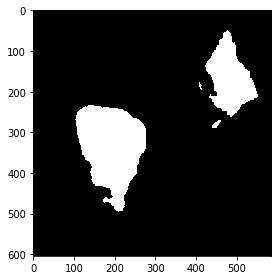

In [160]:
imshow(predict(model, img_path2) > 0.5)

In [105]:
untrained = unet(input_size=(256, 256, 3))

/home/dmitry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


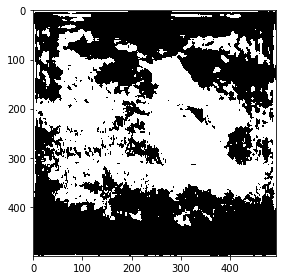

In [138]:
imshow(predict(untrained, img_path1) > 0.37)